In [2]:
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Price_Models as pm
import Data
import Old_code.LSMC as LSMC

In [3]:
# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 256
est_price_path = './Data/est_BS.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,14)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

df = Data.GetData(start_date, df_end, trade_days, Update)

,symbol,optionType,expiration,strike,lastPrice,lastTradeDate,inTheMoney,maturity,S0,sigma,method
0,AAPL,calls,2023-11-17,70.0,111.95,2023-11-09,True,8,182.169998,0.332236,A
1,AAPL,calls,2023-11-17,80.0,102.20,2023-11-09,True,8,182.169998,0.332236,A
2,AAPL,calls,2023-11-17,85.0,97.25,2023-11-09,True,8,182.169998,0.332236,A
3,AAPL,calls,2023-11-17,90.0,92.00,2023-11-09,True,8,182.169998,0.332236,A
4,AAPL,calls,2023-11-17,95.0,87.00,2023-11-09,True,8,182.169998,0.332236,A
...,...,...,...,...,...,...,...,...,...,...,...
12051,^SPX,puts,2027-12-17,6400.0,1657.47,2022-11-30,True,1843,4080.110107,0.233724,E
12052,^SPX,puts,2027-12-17,7200.0,2238.97,2022-11-30,True,1843,4080.110107,0.233724,E
12053,^SPX,calls,2027-12-17,3200.0,1263.84,2023-03-13,True,1740,3855.760010,0.230280,E
12054,^SPX,puts,2027-12-17,1400.0,21.30,2023-07-05,False,1626,4446.819824,0.224982,E


In [87]:
stock = '^SPX'
r = 0.0553
dsigma = 0 
n = 1000 #Sample size
iterations = 100 # max tries
df = df[df['symbol'] == stock]

#Take training sample
df = df.sample(n)

LSMC_est_price = [] 
BIN_est_price = [] 
BS_est_price = [] 
MJD_est_price = []

In [88]:
def compute_errors(dsigma, r):
    LSMC_est_price = [] 
    BIN_est_price = [] 
    BS_est_price = [] 
    MJD_est_price = []
    
    for i in range(len(df)):
        S0 = df.iloc[i].S0       # Sets S0
        K = df.iloc[i].strike
        T = df.iloc[i].maturity / 365
        sigma = df.iloc[i].sigma + dsigma
        type = df.iloc[i].optionType

        # computed_price_LSMC = LSMC.LSMC(S0, K, T, sigma, r, type)
        # computed_price_BIN = pm.BinomialTree(S0, K, T, sigma, r, type)
        computed_price_BS = pm.BS(S0, K, T, sigma, r, type)
        computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type)
        
        # LSMC_est_price.append(computed_price_LSMC)
        # BIN_est_price.append(computed_price_BIN)
        BS_est_price.append(computed_price_BS)
        MJD_est_price.append(computed_price_MJD)

    # LSMC_perc_error = (df.lastPrice - LSMC_est_price)/df.lastPrice
    # BIN_perc_error = (df.lastPrice - BIN_est_price)/df.lastPrice
    BS_perc_error = (df.lastPrice - BS_est_price)/df.lastPrice
    MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice

    averageBS = np.sqrt(np.mean((BS_perc_error)**2))
    averageLSMC = np.sqrt(np.mean((MJD_perc_error)**2))

    return averageBS, averageLSMC

In [89]:
def testvalues_sigma():
    r = 0.0553
    dsigma = -0.1 
    errors = compute_errors(dsigma, r)
    df_errors = pd.DataFrame({'dsigma': dsigma, 'r': r, 'BSerror' : errors[0], 'MJDerror' : errors [1]},index=[0])
    dsigma -= abs(0.05*np.random.randn())

    for i in tqdm(range(iterations)):
        errors = compute_errors(dsigma, r)
        df_errors.loc[i+1] = [dsigma,r,errors[0],errors [1]]
        dsigma += 0.01*(np.random.randn())

    return df_errors



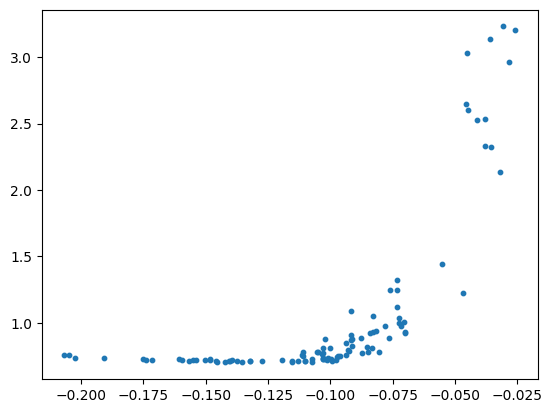

In [78]:
plt.scatter(values.dsigma, values.BSerror, s=10)

In [90]:
def testvalues_r():
    r = 0.1
    dsigma = -0.125
    errors = compute_errors(dsigma, r)
    df_errors = pd.DataFrame({'dsigma': dsigma, 'r': r, 'BSerror' : errors[0]},index=[0])
    r += abs(0.1*np.random.randn())

    for i in tqdm(range(iterations)):
        errors = compute_errors(dsigma, r)
        df_errors.loc[i+1] = [dsigma,r,errors[0]]
        r += 0.03*(np.random.rand() - 0.5)
        r = abs(r)

    return df_errors

values_r = testvalues_r()
values_sigma = testvalues_sigma()



100%|██████████| 100/100 [04:50<00:00,  2.90s/it]


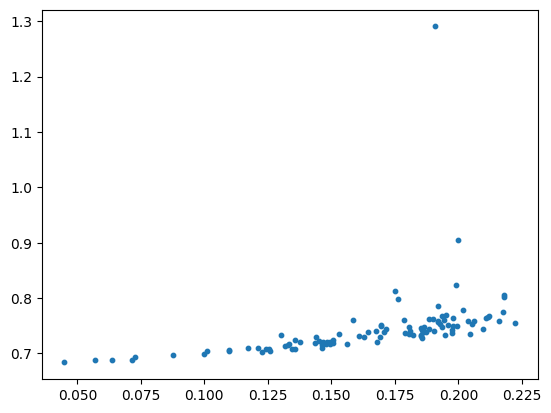

In [91]:
plt.scatter(values_r.r, values_r.BSerror, s=10)

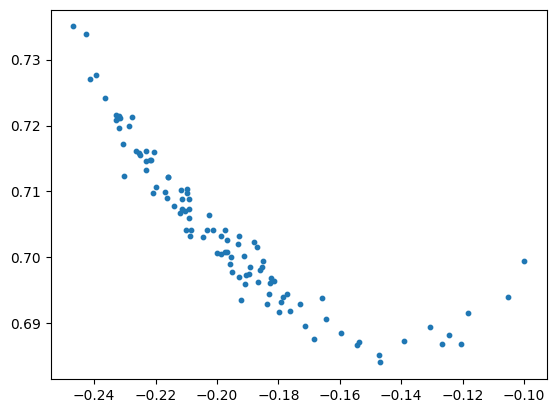

In [92]:
plt.scatter(values_sigma.dsigma, values_sigma.BSerror, s=10)

In [ ]:
def compute_errors_American(dsigma, r):
    LSMC_est_price = [] 
    BIN_est_price = [] 
    BS_est_price = [] 
    MJD_est_price = []
    
    for i in range(len(df)):
        S0 = df.iloc[i].S0       # Sets S0
        K = df.iloc[i].strike
        T = df.iloc[i].maturity / 365
        sigma = df.iloc[i].sigma + dsigma
        type = df.iloc[i].optionType

        computed_price_LSMC = LSMC.LSMC(S0, K, T, sigma, r, type)
        computed_price_BIN = pm.BinomialTree(S0, K, T, sigma, r, type)
        #computed_price_BS = pm.BS(S0, K, T, sigma, r, type)
        #computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type)
        
        LSMC_est_price.append(computed_price_LSMC)
        BIN_est_price.append(computed_price_BIN)
        # BS_est_price.append(computed_price_BS)
        # MJD_est_price.append(computed_price_MJD)

    LSMC_perc_error = (df.lastPrice - LSMC_est_price)/df.lastPrice
    BIN_perc_error = (df.lastPrice - BIN_est_price)/df.lastPrice
    # BS_perc_error = (df.lastPrice - BS_est_price)/df.lastPrice
    # MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice

    averageLSMC = np.sqrt(np.mean((LSMC_perc_error)**2))
    averageBIN = np.sqrt(np.mean((BIN_perc_error)**2))

    return averageLSMC, averageBIN

def testvalues_sigma():
    r = 0.0553
    dsigma = -0.1 
    errors = compute_errors_American(dsigma, r)
    df_errors = pd.DataFrame({'dsigma': dsigma, 'r': r, 'BSerror' : errors[0], 'MJDerror' : errors [1]},index=[0])
    dsigma -= abs(0.05*np.random.randn())

    for i in tqdm(range(iterations)):
        errors = compute_errors_American(dsigma, r)
        df_errors.loc[i+1] = [dsigma,r,errors[0],errors [1]]
        dsigma += 0.01*(np.random.randn())

    return df_errors

def testvalues_r():
    r = 0.1
    dsigma = -0.125
    errors = compute_errors_American(dsigma, r)
    df_errors = pd.DataFrame({'dsigma': dsigma, 'r': r, 'BSerror' : errors[0]},index=[0])
    r += abs(0.1*np.random.randn())

    for i in tqdm(range(iterations)):
        errors = compute_errors_American(dsigma, r)
        df_errors.loc[i+1] = [dsigma,r,errors[0]]
        r += 0.03*(np.random.rand() - 0.5)
        r = abs(r)

    return df_errors

values_r = testvalues_r()
values_sigma = testvalues_sigma()

In [ ]:
#adapt r to error trend
if errors[0] < errors.iloc[i].BSerror :
    direction = (r > errors.iloc[i].r) * 2 - 1
if errors[0] > errors.iloc[i].BSerror :
    direction = (r > errors.iloc[i].r) * -2 + 1
r = direction * 0.05*np.random.rand() 